In [30]:
import sys, os, torch, torchvision
import numpy as np
sys.path.append('/mfs/haoyu/project/CDCNN/ICNN/Official_Model_For_Paper/ModelTraining/TwoStep_Algorithm1_Clip')
from resnet_std import resent as resnet_std
from resnet_std import ResNet
from VOCPart import VOCPart
from tqdm import tqdm
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
device_str = "cuda:0"
device = torch.device(device_str)

In [31]:

ResNet.forward = ResNet.get_feature_map

# res152_bs32_adam_lr1e-5_lrreg1e-3_lmd1e-3_frozen_frz5:4_pre10-3:2     epoch110
# res152_bs32_adam_lr1e-3_lrreg1e-3_lmd1e-3_frozen_6:2                  epoch150
exp_dir = { 'LSG': '/mfs/haoyu/project/CDCNN/ICNN_exp/VOCPart_train0.7_128_pretrained/res152_bs32_adam_lr1e-5_lrreg1e-3_lmd1e-3_frozen_frz5:4_pre10-3:2',
            'naive' : '/mfs/haoyu/project/CDCNN/ICNN_exp/VOCPart_train0.7_128_pretrained/naive_res152_bs32_adam_lr1e-5_lrreg1e-3_lmd1e-3_frozen_3:2'}
# naive_res152_bs32_adam_lr1e-5   epoch110
# naive_res152_bs32_adam_lr1e-5_lrreg1e-3_lmd1e-3_frozen_3:2   epoch150
model = {} 
for method in ['LSG', 'naive']:
    ifmask = method == 'LSG'
    model[method] = resnet_std(depth=152, num_classes=6, pretrained=True, ifmask=ifmask)
    model[method] = model[method].to(device)
    model[method] = torch.nn.DataParallel(model[method]) # device_ids=args.gpu_ids
    # patch_replication_callback(model)
    unfinished_model_path = os.path.join(exp_dir[method] , 'unfinished_model_150.pt')
    checkpoint = torch.load(unfinished_model_path,map_location={'cuda:0': device_str})
    model[method].load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']+1
# loss = checkpoint['loss']


mask (2048, 6)


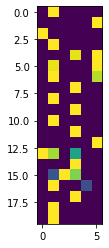

In [32]:
mask = model['LSG'].module.lmask.mask.detach().cpu().numpy()
print('mask',mask.shape)
from matplotlib import pyplot as plt
plt.imshow(mask[0:20,:])
plt.show()

num_channel, num_class = mask.shape

In [33]:
dataset = VOCPart('/home/haoyu/data/VOCPart', train=False, requires=['img'], size=128)
dataloader = torch.utils.data.DataLoader(dataset,
                batch_size=32, pin_memory=True,
                shuffle=False, num_workers=16)

threshold_probability = 0.05  #  0.005
num_large = int( threshold_probability * 4 *4 * len(dataset) )


# class Largest(object):
#     def __init__(self, size):
#         self.largests = []
#         self.size= size
#     def add(self, x):
#         if  len(self.largests)<self.size:
#             self.largests.append(x)
#             self.largests=sorted(self.largests)
#         elif x > self.largests[0]:
#             self.largests[0]=x
#             self.largests=sorted(self.largests)
#     def smallest(self):
#         return self.largests[0]
threshold = {}
for method in ['LSG', 'naive']:
    activations = np.zeros((num_channel, len(dataset)*16))

    # largests = Largest(num_large)
    # for x in range(1000):
    #     largests.add(x)

    # largsest = [Largest(num_large) for i in range(num_channel)]

    for batch_id, (imgs, labels) in enumerate(dataloader):
        
        fmap = model[method](imgs)
        bs, n_channel, _, _ =fmap.shape
        fmap = fmap.view(bs, n_channel, -1)

        activations_channels = torch.cat((*fmap, ), 1) # num_channel, batch_size * 16

        activations[:, (batch_id*bs*16):((batch_id+1)*bs*16)] = activations_channels.detach().cpu().numpy()
    
        print(method,'img_num =', batch_id * bs, end='\r')
        # for channel, activations in enumerate(activations_channels):
        #     # print('activations.shape',activations.shape)
        #     for x in activations:
        #         x = x.item()
        #         # print(type(x),x)
        #         largsest[channel].add(x)
        #     # break
        # # break
    activations_sort = np.sort(activations, axis=1)
    threshold[method] = activations_sort[:,-num_large]

print()
print(threshold['LSG'])
print(threshold['naive'])
# activations.size()

val set
image size 128x128
image num = 1700
naive img_num = 212

In [0]:
dataset = VOCPart('/home/haoyu/data/VOCPart', train=False, requires=['img','obj_mask', 'part_mask'], size=128)
dataloader = torch.utils.data.DataLoader(dataset,
                batch_size=32, pin_memory=True,
                shuffle=False, num_workers=16)

In [0]:
num_class = 6
# threshold = 1


# num_class = 6
# num_channel = 2048

def dev_zero_replace(a,b):
    return np.divide(a, b,
             out=np.zeros_like(a/1.0),
             where=(b!=0))


def get_IoU(fmap, obj_mask, _threshold=None, top_rate=None):
    # 皆是 torch.tensor(1,128,128)

    # fmap = fmap[0]

    # print('fmap', fmap.shape)
    # plt.imshow(fmap, cmap='gray')
    # plt.show()


    fmap = torch.nn.functional.interpolate(fmap.view(1,1,4,4), 128, mode='bilinear', align_corners=False) [0]
    # print('fmap', fmap.shape)

    fmap = fmap[0]
    obj_mask = obj_mask[0]    

    # print('fmap', fmap.shape)
    if top_rate!=None and _threshold==None:
        top_num = int(torch.numel(fmap) * top_rate)
        # print(top_num)
        value,index=fmap.view([-1]).sort()
        # print(value)
        _threshold = value[-top_num]
    # print('_threshold', _threshold)

    # plt.imshow(fmap, cmap='gray')
    # plt.show()

    # plt.imshow(obj_mask, cmap='gray')
    # plt.show()

    # print('fmap max=',fmap.max(), 'min=',fmap.min())
    # print('obj_mask max=',obj_mask.max(), 'min=',obj_mask.min())

    # print('obj_mask.dtype=',obj_mask.dtype)
    fmaask=(fmap >= _threshold).float()
    # print('fmaask.dtype=',fmaask.dtype)

    # print('fmaask max=',fmaask.max(), 'min=',fmaask.min())
    # plt.imshow(fmaask, cmap='gray')
    # plt.show()

    union = torch.max(fmaask,obj_mask)
    # plt.imshow(union, cmap='gray')
    # plt.show()

    intersect = torch.min(fmaask,obj_mask)
    # plt.imshow(intersect, cmap='gray')
    # plt.show()

    _UoI = intersect.sum()/union.sum()
    # print('IoU =', _UoI)

    return _UoI.item()

cam_top_rate = 0.3
cam_UoI_threshold = 0.2

UoI_threshold = 0.04

In [29]:

def take(x,coords):
    # coords = np.array(每列是个坐标)
    return np.take(x, np.ravel_multi_index(coords, x.shape))


pbar = tqdm(bar_format='{desc}',leave=True)

sum_IoU = {'LSG': np.zeros(mask.shape), 'naive' :  np.zeros(mask.shape)}
sum_success = {'LSG': np.zeros(mask.shape), 'naive' :  np.zeros(mask.shape)}
num = {'LSG': np.zeros(mask.shape), 'naive' :  np.zeros(mask.shape)}
mean_IoU = {'LSG': 0.0, 'naive' : 0.0}
mean_score_filter = {'LSG': 0.0, 'naive' : 0.0}

sum_cam_IoU = {'LSG':  0.0 , 'naive' : 0.0 }
sum_cam_related =  {'LSG':  0 , 'naive' : 0 }
num_cam =  {'LSG':  0.0 , 'naive' : 0.0 }
mean_cam_IoU = {'LSG':  0.0 , 'naive' : 0.0 }
mean_cam_related = {'LSG':  0.0 , 'naive' : 0.0 }

for img_id,(img, label, obj_mask, part_mask) in enumerate(dataset):
    # print(label )
    # print(*img.shape)
    img = img.view(1,*img.shape).to(device)
    for method in ['LSG', 'naive']:
        feature_map = model[method](img)[0].detach().cpu()
        # cam = feature_map *

        # weight = model[method].module.fc.weight.detach().cpu() # [6, 2048]
        # weight = weight[label]
        # # print('weight', type(weight), weight.dtype, weight.shape) # <class 'torch.Tensor'> torch.float32 torch.Size([2048])
        # # print('feature_map', type(feature_map), feature_map.dtype, feature_map.shape) # <class 'torch.Tensor'> torch.float32 torch.Size([2048, 4, 4])
        # cam = ( feature_map * weight.view([-1,1,1]) ).sum(axis=0)
        # # print('cam', cam.shape, cam.min(), cam.max()) # cam torch.Size([4, 4])

        # cam_IoU = get_IoU(cam, obj_mask, top_rate=cam_top_rate)
        # # print('cam_IoU =', cam_IoU)

        # sum_cam_IoU[method] += cam_IoU
        # sum_cam_related[method] += int(cam_IoU>cam_UoI_threshold)
        # num_cam[method] += 1

        # mean_cam_IoU[method] = sum_cam_IoU[method] / num_cam[method]
        # mean_cam_related[method] = sum_cam_related[method] / num_cam[method]



        # sys.exit(0)
        for channel, fmap in enumerate(feature_map):

            fmap = fmap
            # print('feature_map', feature_map.shape)

            IoU = get_IoU(fmap, obj_mask, threshold[method][channel])
            # print('IoU =', IoU)

            sum_IoU[method][channel, label] = IoU
            sum_success[method][channel, label] += int(IoU>UoI_threshold)
            num[method][channel, label] += 1


        # mean_IoU_matrix = dev_zero_replace(sum_IoU[method], num[method])
        # mean_IoU[method] = mean_IoU_matrix.max(axis=1).mean(axis=0)

        mean_success = dev_zero_replace(sum_success[method], num[method])
        score_filter = mean_success.max(axis=1)
        mean_score_filter[method] = score_filter.mean(axis=0)



        idx = mean_success.argmax(axis=1)
        mean_IoU_matrix = dev_zero_replace(sum_IoU[method], num[method])
        coords = np.array([range(mean_IoU_matrix.shape[0]),idx])
        IoU_related_class = take(mean_IoU_matrix, coords)
        mean_IoU[method] = IoU_related_class.mean(axis=0)

    pbar.set_description_str( 'img_id %d -  LSG:naive ||  filter UoI %5f : %5f | acc %5f : %5f |'  % ( img_id,
        mean_IoU['LSG'], mean_IoU['naive'] ,  mean_score_filter['LSG'], mean_score_filter['naive'] ) )
    pbar.update()






# meanIoU = sum/num



NameError: name 'tqdm' is not defined

In [7]:
# pbar_cam.close()
pbar.close()
# print('mean_cam_IoU', mean_cam_IoU, 'mean_cam_related', mean_cam_related, end='\r')



img_id 19 - cam  LSG:naive | mean 0.273590 : 0.238348 | num_related_iamges 0.700000 : 0.650000
img_num     19  mean_score_filter LSG : naive = 0.304492 : 0.186108mean_cam_IoU {'LSG': 0.26318525416510447, 'naive': 0.22699817695787974} mean_cam_related {'LSG': 0.6666666666666666, 'naive': 0.6190476190476191}


In [8]:
related_filter_num = {}
related_filter_mean_score = {}

for method in ['LSG', 'naive']:
    meanIoU = dev_zero_replace(sum[method], num[method])
    score_filter = meanIoU.max(axis=1)
    filter_related_class = meanIoU.argmax(axis=1)
    related_filter_num[method]=np.zeros(num_class)
    related_filter_mean_score[method]=np.zeros([num_class])
    for cid, class_name in enumerate(dataset.classes):
        score_related_to_class = score_filter[filter_related_class==cid]
        related_filter_num[method][cid] = len(score_related_to_class)
        related_filter_mean_score[method][cid] = score_related_to_class.mean() 

print(*dataset.classes, sep=',')
for method in ['LSG', 'naive']:
    print(method)
    print('related_filter_num',*related_filter_num[method], sep=',')
    print('related_filter_mean_score',*related_filter_mean_score[method], sep=',')
    print('average_score', (related_filter_num[method]*related_filter_mean_score[method]).sum() / related_filter_num[method].sum() , sep=',')

TypeError: 'builtin_function_or_method' object is not subscriptable

In [11]:
pbar = tqdm(bar_format='{desc}',leave=True) 

sum_cam_IoU = {'LSG':  0.0 , 'naive' : 0.0 }
sum_cam_related =  {'LSG':  0 , 'naive' : 0 }
num_cam =  {'LSG':  0.0 , 'naive' : 0.0 }
mean_cam_IoU = {'LSG':  0.0 , 'naive' : 0.0 }
mean_cam_related = {'LSG':  0.0 , 'naive' : 0.0 }

sum_cam_UoI_class = {'LSG': np.zeros(num_class), 'naive' :  np.zeros(num_class)} 
num_cam_UoI_class = {'LSG': np.zeros(num_class), 'naive' :  np.zeros(num_class)} 
mean_cam_UoI_class = {'LSG': np.zeros(num_class), 'naive' :  np.zeros(num_class)} 

for img_id,(img, label, obj_mask, part_mask) in enumerate(dataset):
    # print(label )
    # print(*img.shape)
    img = img.view(1,*img.shape).to(device)
    for method in ['LSG', 'naive']:
        feature_map = model[method](img)[0].detach().cpu()
        # cam = feature_map * 

        weight = model[method].module.fc.weight.detach().cpu() # [6, 2048]
        weight = weight[label]
        # print('weight', type(weight), weight.dtype, weight.shape) # <class 'torch.Tensor'> torch.float32 torch.Size([2048])
        # print('feature_map', type(feature_map), feature_map.dtype, feature_map.shape) # <class 'torch.Tensor'> torch.float32 torch.Size([2048, 4, 4])
        cam = ( feature_map * weight.view([-1,1,1]) ).sum(axis=0)
        # print('cam', cam.shape, cam.min(), cam.max()) # cam torch.Size([4, 4])

        cam_IoU = get_IoU(cam, obj_mask, top_rate=cam_top_rate)
        # print('cam_IoU =', cam_IoU)
        
        sum_cam_IoU[method] += cam_IoU
        sum_cam_related[method] += int(cam_IoU>cam_UoI_threshold)
        num_cam[method] += 1

        mean_cam_IoU[method] = sum_cam_IoU[method] / num_cam[method]
        mean_cam_related[method] = sum_cam_related[method] / num_cam[method]

        sum_cam_UoI_class[method][label] += cam_IoU
        num_cam_UoI_class[method][label] += 1

        mean_cam_UoI_class[method] = dev_zero_replace(sum_cam_UoI_class[method], num_cam_UoI_class[method])

    pbar.set_description_str(  ( 'LSG ' + num_class*'%5f '+' | naive ' + num_class*'%5f '+' | ')%(*mean_cam_UoI_class['LSG'], *mean_cam_UoI_class['naive']) )
    pbar.update()
pbar.close()









LSG 0.223812 0.000000 0.000000 0.000000 0.000000 0.000000  | naive 0.116618 0.000000 0.000000 0.000000 0.000000 0.000000  |


LSG 0.223812 0.000000 0.000000 0.000000 0.000000 0.000000  | naive 0.116618 0.000000 0.000000 0.000000 0.000000 0.000000  |


LSG 0.223812 0.000000 0.000000 0.000000 0.000000 0.130909  | naive 0.116618 0.000000 0.000000 0.000000 0.000000 0.325658  |


LSG 0.223812 0.000000 0.000000 0.000000 0.000000 0.130909  | naive 0.116618 0.000000 0.000000 0.000000 0.000000 0.325658  |


LSG 0.260239 0.000000 0.000000 0.000000 0.000000 0.130909  | naive 0.201195 0.000000 0.000000 0.000000 0.000000 0.325658  |


LSG 0.260239 0.000000 0.000000 0.000000 0.000000 0.130909  | naive 0.201195 0.000000 0.000000 0.000000 0.000000 0.325658  |


LSG 0.260239 0.000000 0.387680 0.000000 0.000000 0.130909  | naive 0.201195 0.000000 0.242177 0.000000 0.000000 0.325658  |


LSG 0.260239 0.000000 0.387680 0.000000 0.000000 0.130909  | naive 0.201195 0.000000 0.242177 0.000000 0.000000 

KeyboardInterrupt: 

In [24]:
import numpy as np
a = np.random.rand(2,4)

In [25]:
a

array([[0.08875532, 0.41541718, 0.09725226, 0.82855304],
       [0.56296417, 0.97682151, 0.8819183 , 0.90167334]])

In [26]:
idx = a.argmax(1)
idx

array([3, 1])

In [27]:
coords = np.array([range(a.shape[0]),idx])



In [28]:
coords = np.array([range(a.shape[0]),idx])
def take(x,coords):
    # coords = np.array(每列是个坐标)
    return np.take(x, np.ravel_multi_index(coords, x.shape))
take(a, coords)

array([0.82855304, 0.97682151])